In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d arjuntejaswi/plant-village

 99% 326M/329M [00:03<00:00, 134MB/s]
100% 329M/329M [00:03<00:00, 107MB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/plant-village.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import os
import shutil

# Path to the folder containing all classes
source_folder = '/content/PlantVillage'

# Path to the destination folder for the "potato" class
potato_class_folder = '/content/potato'

# Create the destination folder if it doesn't exist
if not os.path.exists(potato_class_folder):
    os.makedirs(potato_class_folder)

# List all files in the source folder
all_files = os.listdir(source_folder)

# Filter files for the "potato" class and move them to the destination folder
potato_files = [file for file in all_files if 'potato' in file.lower()]
for file in potato_files:
    source_path = os.path.join(source_folder, file)
    destination_path = os.path.join(potato_class_folder, file)
    shutil.move(source_path, destination_path)

# List the contents of the "potato_class" folder
os.listdir(potato_class_folder)


['Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight']

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/potato",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


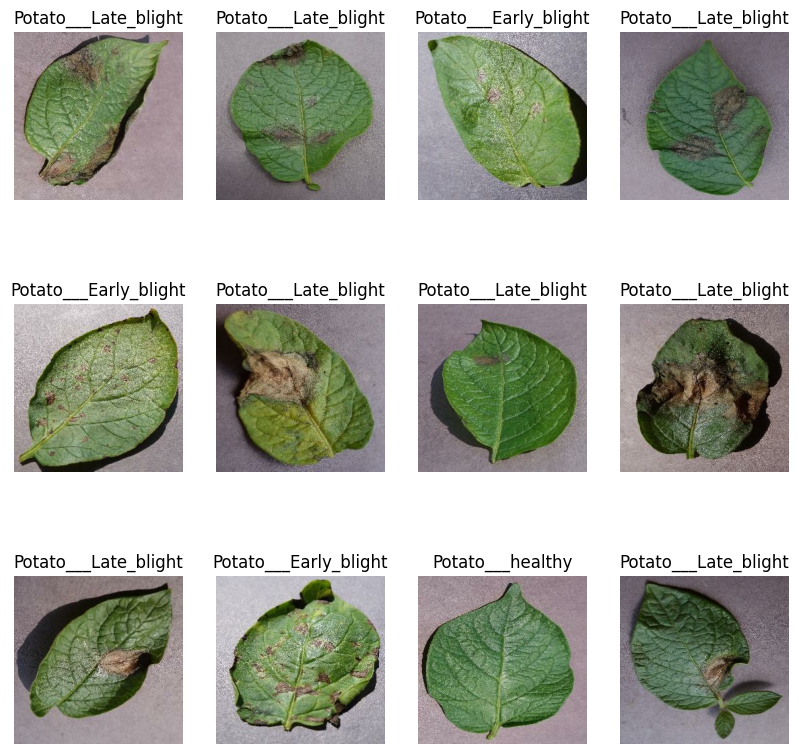

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 295s 5s/step - loss: 0.8791 - accuracy: 0.5203 - val_loss: 0.9539 - val_accuracy: 0.5729
Epoch 2/10
54/54 [==============================] - 265s 5s/step - loss: 0.5623 - accuracy: 0.7598 - val_loss: 0.4142 - val_accuracy: 0.8281
Epoch 3/10
54/54 [==============================] - 255s 5s/step - loss: 0.3311 - accuracy: 0.8750 - val_loss: 0.4208 - val_accuracy: 0.8214
Epoch 4/10
54/54 [==============================] - 254s 5s/step - loss: 0.2919 - accuracy: 0.8698 - val_loss: 0.2857 - val_accuracy: 0.8958
Epoch 5/10
54/54 [==============================] - 245s 5s/step - loss: 0.2340 - accuracy: 0.9120 - val_loss: 0.2205 - val_accuracy: 0.9115
Epoch 6/10
54/54 [==============================] - 247s 5s/step - loss: 0.2148 - accuracy: 0.9225 - val_loss: 0.3616 - val_accuracy: 0.8646
Epoch 7/10
54/54 [==============================] - 245s 5s/step - loss: 0.1926 - accuracy: 0.9225 - val_loss: 0.1318 - val_accuracy: 0.9375
Epoch 8/10
54

In [ ]:
scores = model.evaluate(test_ds)

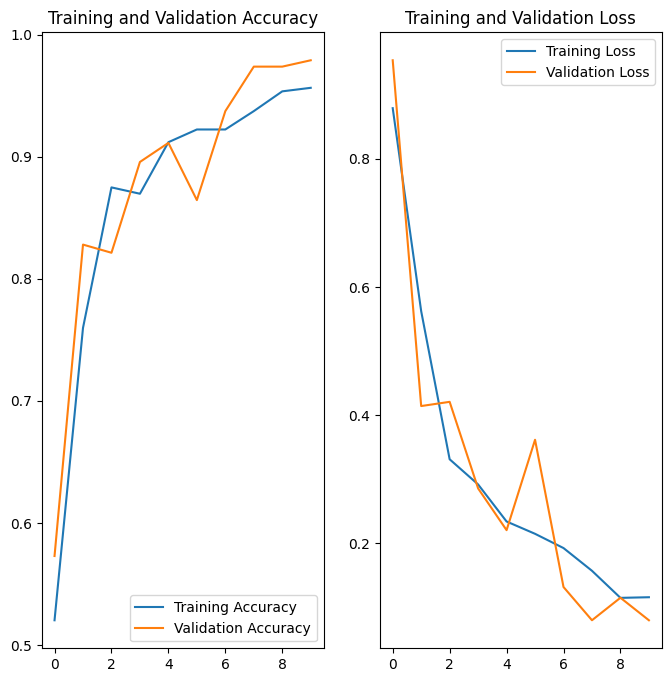

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


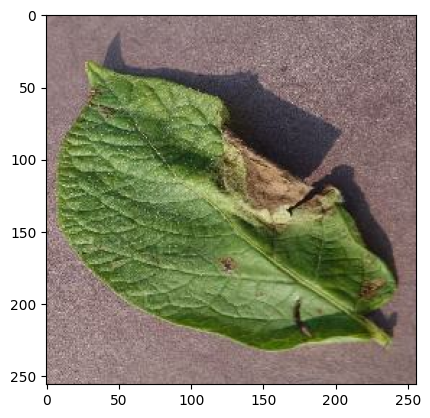

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])